In [1]:
import os

DataSample = dict[str, str]

def collect_data(images_dir : str, labels_dir : str) -> list[DataSample]:
    images = sorted(os.listdir(images_dir))
    labels = sorted(os.listdir(labels_dir))
    
    data = []
    for image, label in zip(images, labels):
        data.append({"image": os.path.join(images_dir, image), "label": os.path.join(labels_dir, label)})
    
    return data

def collect_dataset(train_dir : str, val_dir : str, test_dir : str) -> dict[str, list[DataSample]]:
    dataset = {"train": [], "val": [], "test": []}
    
    dataset["train"] = collect_data(os.path.join(train_dir, "images"),
                                 os.path.join(train_dir, "labels"))
    dataset["val"] = collect_data(os.path.join(val_dir, "images"),
                                 os.path.join(val_dir, "labels"))
    dataset["test"] = collect_data(os.path.join(test_dir, "images"),
                                 os.path.join(test_dir, "labels"))
    return dataset

ROOT_DIR = "./"
DATASET_PATH = "./data/datasets/astrocyte-1.1"
# DATASET_PATH = "./data"
os.chdir(ROOT_DIR)

dataset = collect_dataset(os.path.join(DATASET_PATH, "train"),
                os.path.join(DATASET_PATH, "val"),
                os.path.join(DATASET_PATH, "test"))

In [6]:
dataset["test"]

[{'image': './data/datasets/astrocyte-1.1/test/images/0101_png.rf.eaff03e973a515def176e99b3bbbb1b2.jpg.npy',
  'label': './data/datasets/astrocyte-1.1/test/labels/0101_png.rf.eaff03e973a515def176e99b3bbbb1b2.txt.npy'},
 {'image': './data/datasets/astrocyte-1.1/test/images/0201_png.rf.80523f2f45061f74159edc048bbd21f0.jpg.npy',
  'label': './data/datasets/astrocyte-1.1/test/labels/0201_png.rf.80523f2f45061f74159edc048bbd21f0.txt.npy'},
 {'image': './data/datasets/astrocyte-1.1/test/images/0302_png.rf.c4281ccc8c53b16d7d70487e825ecf43.jpg.npy',
  'label': './data/datasets/astrocyte-1.1/test/labels/0302_png.rf.c4281ccc8c53b16d7d70487e825ecf43.txt.npy'}]

In [2]:
import numpy as np
import cv2

def load_polygons(file_path):
    polygons = []
    with open(file_path, 'r') as f:
        for line in f:
            coords = list(map(float, line.split(' ')))[1:]
            polygon = [[coords[i], coords[i+1]] for i in range(0, len(coords)-1, 2)]
            polygons.append(polygon)
    return polygons

def polygons_to_mask(polygons, image_size):
    """
    :param polygons: список полигонов, где каждый полигон - список точек [(x1,y1), ...]
    :param image_size: (width, height) выходной маски
    """
    mask = np.zeros((image_size[1], image_size[0]), dtype=np.uint8)
    for polygon in polygons:
        pts = np.array(polygon)
        pts[:, 0] *= image_size[0]
        pts[:, 1] *= image_size[1]
        pts = pts.reshape((-1, 1, 2)).astype(np.int32)
        cv2.fillPoly(mask, [pts], color=1)
    return mask

from PIL import Image

def preprocess(image_src_path, label_src_path, image_dst_path, label_dts_path):
    image = Image.open(image_src_path) # np.load(image_src_path)
    image = np.array(image)
    print(image.shape)
    polygons = load_polygons(label_src_path)
    label = polygons_to_mask(polygons, (512, 512))
    np.save(image_dst_path, image)
    np.save(label_dts_path, label)

In [8]:
# DST_PATH = "./data/datasets/astrocyte-1.1"

# for elem in dataset["test"]:
#     print(elem["image"])
#     preprocess(elem["image"], elem["label"],
#                os.path.join(DST_PATH, "test", "images", os.path.basename(elem["image"])), 
#                os.path.join(DST_PATH, "test", "labels", os.path.basename(elem["label"])))

In [9]:
# import matplotlib.pyplot as plt 
# import numpy as np

# n = len(dataset["train"])
# fig, ax = plt.subplots(1, 5, figsize=(25, 200)); ax : list[plt.Axes]
# for i in range(n):
#     ax[i].imshow(np.load(dataset["val"][i]["label"]))

In [3]:
from monai.data.dataset import Dataset
from monai.data.dataloader import DataLoader
from monai.data import NumpyReader

from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Spacingd, 
    RandFlipd, RandAffined, RandGaussianNoised, RandGaussianSmoothd, 
    NormalizeIntensityd, RandAdjustContrastd, Rand3DElasticd
)

train_transforms = Compose([
    LoadImaged(keys=["image", "label"], reader=NumpyReader),
    EnsureTyped(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["label"]),
    EnsureChannelFirstd(keys=["image"], channel_dim=-1),
    
    # Spacing
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    RandFlipd(keys=["image", "label"], spatial_axis=0, prob=0.5),
    RandAffined(
        keys=["image", "label"], 
        prob=0.7,
        rotate_range=(0.1, 0.1, 0.1), 
        scale_range=(0.1, 0.1, 0.1), 
        translate_range=(5, 5, 5), 
        mode=("bilinear", "nearest")
    ),
    Rand3DElasticd(keys=["image", "label"], prob=0.2, sigma_range=(5, 8), magnitude_range=(100, 200)),

    # Intensity
    NormalizeIntensityd(keys=["image"], channel_wise=True),  # (data - mean) / std
    RandAdjustContrastd(keys=["image"], prob=0.3, gamma=(0.7, 1.5)),
    RandGaussianNoised(keys=["image"], prob=0.15, mean=0, std=0.05),
    RandGaussianSmoothd(keys=["image"], prob=0.1, sigma_x=(0.5, 1.5)),
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"], reader=NumpyReader),
    EnsureTyped(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["label"]),
    EnsureChannelFirstd(keys=["image"], channel_dim=-1),
    
    # Intensity
    NormalizeIntensityd(keys=["image"], channel_wise=True),  # (data - mean) / std
])

train_dataset = Dataset(dataset["train"], train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=4)

val_dataset = Dataset(dataset["val"], val_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=4)

test_dataset = Dataset(dataset["test"], val_transforms)
test_dataloader = DataLoader(test_dataset)

In [4]:
import torch
from monai.networks.nets import AttentionUnet
from monai.losses import DiceLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AttentionUnet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=(64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2),
)
model = model.to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, sigmoid=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [5]:
class Dice():
    def __init__ (self, smooth=1e-6):
        self.smooth = smooth
        self.by_classes = torch.tensor([])
        
    def __call__(self, outputs : torch.Tensor, targets : torch.Tensor):
        self.intersection = (outputs & targets).sum((2, 3))
        self.union = (outputs | targets).sum((2, 3))
        self.by_classes = (2 * self.intersection) / (self.union + self.intersection + self.smooth)
        return self.by_classes.mean(dim=0)
    
    def mean(self):
        return self.by_classes.mean(dim=1).mean(dim=0)

In [6]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(os.path.join("runs", "v.03"))

def write_logs(
    writer : SummaryWriter,
    train_loss : float,
    train_dice : float,
    val_loss : float,
    val_dice : float,
    step : int,
):
    # train
    writer.add_scalar("train/loss", train_loss, step)
    writer.add_scalar("train/mean_dice", train_dice, step)
    
    # validation
    writer.add_scalar("val/loss", val_loss, step)
    writer.add_scalar("val/mean_dice", val_dice, step)

    # compare
    writer.add_scalars("compare/loss", {"train": train_loss, "val": val_loss}, step)
    writer.add_scalars("compare/mean_dice", {"train": train_dice, "val": val_dice}, step)

In [9]:
from torchvision.utils import make_grid
def make_grid_image(images : list[torch.Tensor]):
    for i in range(len(images)):
        images[i] = torch.Tensor(images[i])[0].cpu()
        if images[i].size(0) == 1:
            images[i] = images[i].repeat(3, 1, 1)

    return make_grid(images)

In [10]:
from tqdm import tqdm

epochs = 3
dice = Dice()
best_dice = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_mean_dice = 0
    for batch in tqdm(train_dataloader):
        batch  : dict[str, torch.Tensor]
        inputs, targets = batch["image"].to(device), batch["label"].to(device)
        
        outputs = model(inputs); outputs : torch.Tensor
        loss = loss_function(outputs, targets); loss : torch.Tensor
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        
        mask = (torch.sigmoid(outputs) > 0.5).int()
        targets = targets.int()
        
        dice(mask, targets); mean_dice = dice.mean()
        train_mean_dice += mean_dice
    
    val_loss = 0
    val_mean_dice = 0
    with torch.no_grad():
        model.eval()
        for batch in tqdm(val_dataloader):
            batch : dict[str, torch.Tensor]
            inputs, targets = batch["image"].to(device), batch["label"].to(device)

            outputs = model(inputs); outputs : torch.Tensor
            loss = loss_function(outputs, targets); loss : torch.Tensor
            val_loss += loss.item()
            
            mask = (torch.sigmoid(outputs) > 0.5).int()
            targets = targets.int()
            
            dice(mask, targets); mean_dice = dice.mean()
            val_mean_dice += mean_dice
    
            last_batch = batch
            last_batch["pred"] = outputs

    train_loss /= len(train_dataloader)
    train_mean_dice /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mean_dice /= len(val_dataloader)
    print(f"{epoch+1}/{epochs}: train_loss={train_loss:.5}, train_mean_dice={train_mean_dice:.5}")
    print(f"{epoch+1}/{epochs}: val_loss={val_loss:.5}, val_mean_dice={val_mean_dice:.5}")
    
    if best_dice < val_mean_dice:
        best_dice = val_mean_dice
        torch.save(model.state_dict(), os.path.join("checkpoints", "best.pth"))
    else:
        print(f"No improvement in val mean dice, skip saving checkpoint best_dice={best_dice:.5}")
    write_logs(writer, train_loss, train_mean_dice, val_loss, val_mean_dice, epoch+1)
    grid_image = make_grid_image([inputs, targets, outputs])
    writer.add_image("val/image_grid", grid_image, epoch+1)

100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


1/3: train_loss=0.96578, train_mean_dice=0.075828
1/3: val_loss=0.94711, val_mean_dice=0.22409


100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


2/3: train_loss=0.95652, train_mean_dice=0.16789
2/3: val_loss=0.93889, val_mean_dice=0.23926


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


3/3: train_loss=0.94918, train_mean_dice=0.23324
3/3: val_loss=0.93588, val_mean_dice=0.24294


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6399076..3.8660448].


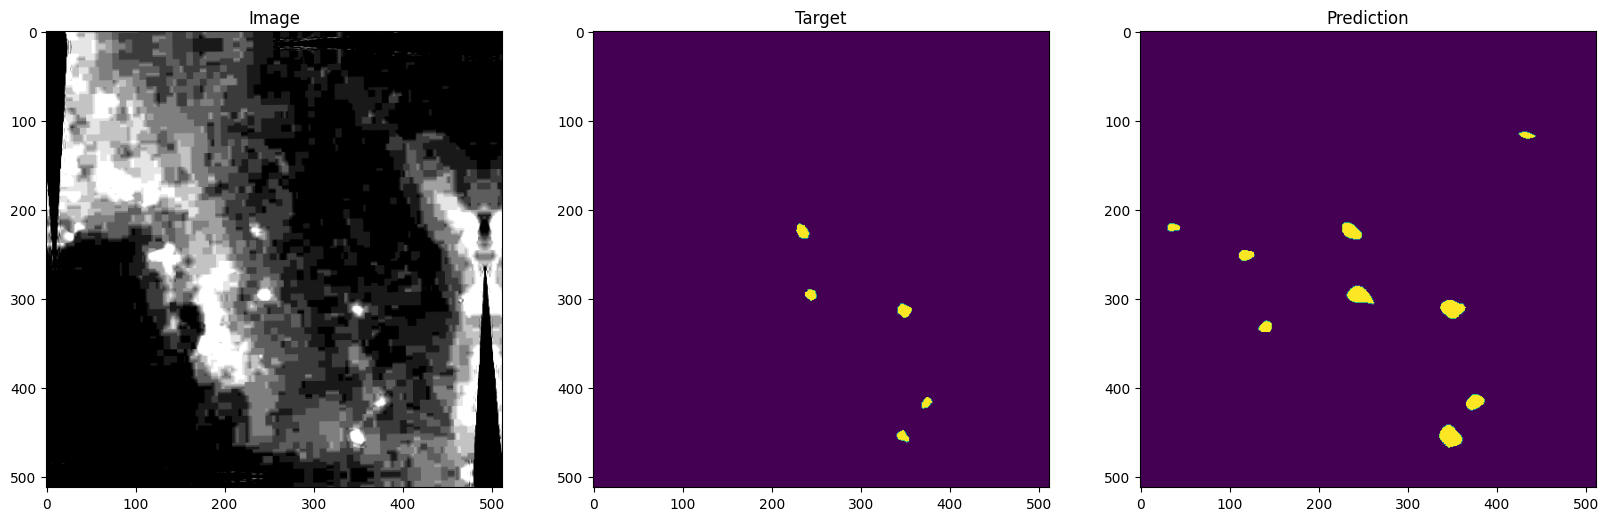

In [ ]:
import matplotlib.pyplot as plt
import skimage

def show_result(inputs : torch.Tensor, targets : torch.Tensor, outputs : torch.Tensor):
    inputs = inputs.clone().cpu()
    targets = targets.clone().cpu()
    outputs = outputs.clone().cpu()
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 20))
    ax[0].imshow(inputs)
    ax[1].imshow(targets)
    ax[2].imshow(outputs)
    ax[0].set_title("Image")
    ax[1].set_title("Target")
    ax[2].set_title("Prediction")
    plt.show()

targets = targets.squeeze(dim=1)
mask = mask.squeeze(dim=1)

show_result(inputs[0].permute(1, 2, 0), targets[0], mask[0])

In [ ]:
inputs_list = []
targets_list = []
preds_list = []

with torch.no_grad():
    model.eval()    
    for batch in tqdm(test_dataloader):
        inputs, targets = batch["image"].to(device), batch["label"].to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        
        mask = (torch.sigmoid(outputs) > 0.9).int()
        targets = targets.int()
        
        dice(mask, targets); mean_dice = dice.mean()
        # test_mean_dice += mean_dice
        
        print(f": test_mean_dice={mean_dice:.5}")
        inputs_list.append(inputs); targets_list.append(targets); preds_list.append(mask)
        # test_mean_dice /= len(train_dataloader)

100%|██████████| 3/3 [00:00<00:00, 27.82it/s]

: test_mean_dice=0.6296
: test_mean_dice=0.42061
: test_mean_dice=0.54273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1431718..30.205423].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.628204..16.834822].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.981303..15.633711].


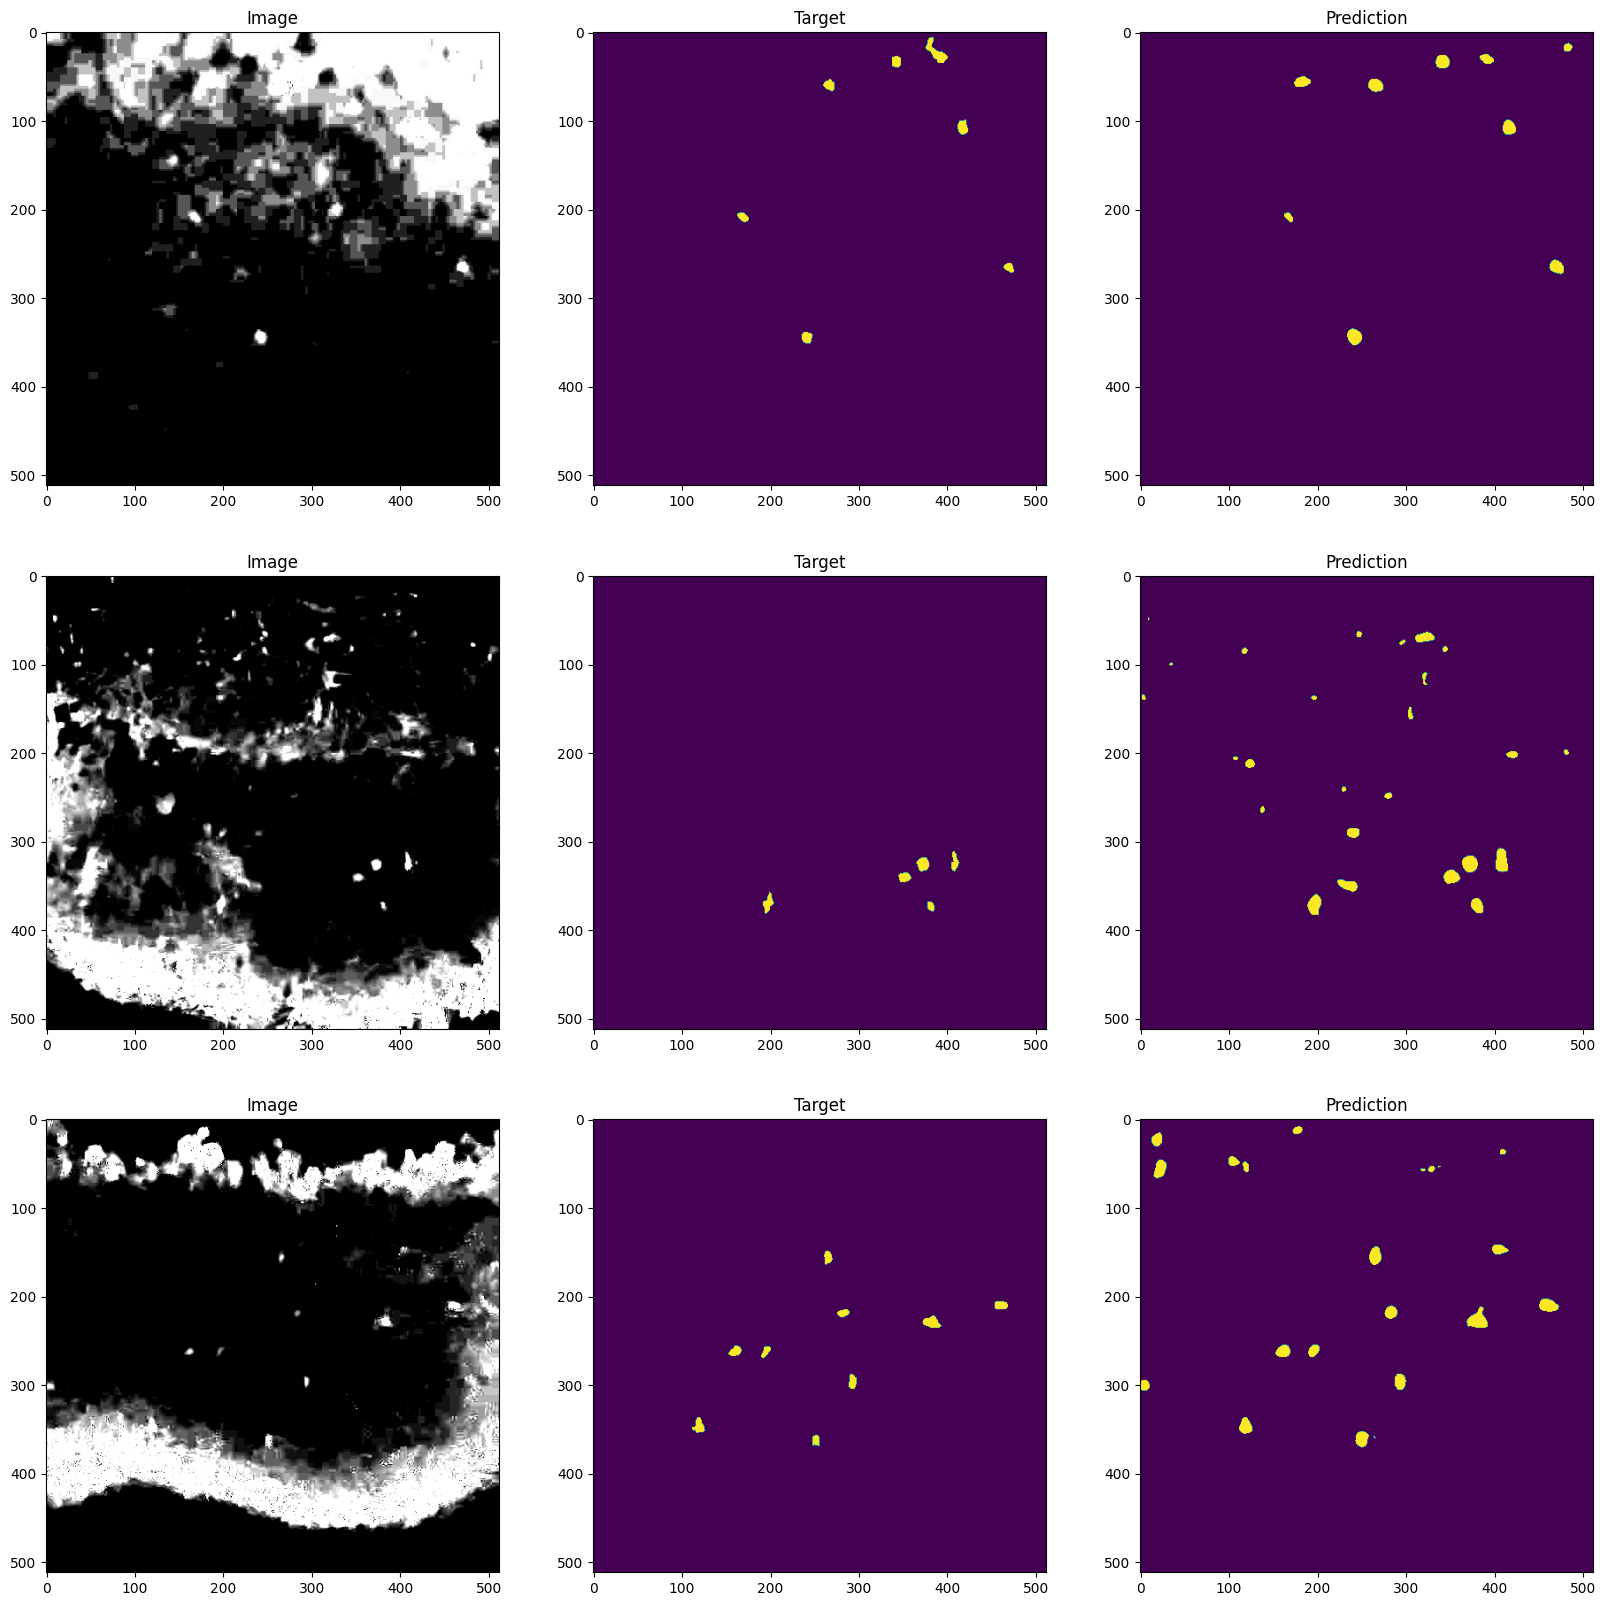

In [ ]:
import matplotlib.pyplot as plt
import skimage

def show_result(inputs_list : torch.Tensor, targets_list : torch.Tensor, outputs_list : torch.Tensor):
    fig, ax = plt.subplots(3, 3, figsize=(20, 20)); ax : list[plt.Axes]
    for i in range(3):
        inputs = inputs_list[i][0].permute(1, 2, 0).clone().cpu()
        targets = targets_list[i][0].squeeze(dim=0).clone().cpu()
        outputs = outputs_list[i][0].squeeze(dim=0).clone().cpu()
        ax[i, 0].imshow(inputs)
        ax[i, 1].imshow(targets)
        ax[i, 2].imshow(outputs)
        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Target")
        ax[i, 2].set_title("Prediction")
        
    
    # plt.show()

show_result(inputs_list, targets_list, preds_list)